In [32]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

 <h2><center>Purpose</center></h2>Purpose
The following code assembles a series of lagrangians which can be used to set up two coupled differential equations. These equations are then solved to give an animation in matplotlib. The current animation chosen will be a 2D animation of the 3 body problem from classical physics.

In [33]:
#here we define our variables and functions for sympy to use
G = smp.symbols('G')
t = smp.symbols('t')
m1,m2,m3 = smp.symbols('m_{1} m_{2} m_{3}')
x1,x2,x3,y1,y2,y3 = smp.symbols('x_{1} x_{2} x_{3} y_{1} y_{2} y_{3}', cls=smp.Function)

x1=x1(t)
x2=x2(t)
x3=x3(t)
y1=y1(t)
y2=y2(t)
y3=y3(t)

In [34]:
#I decided to organize the valiables into a matrix setup so it's easier for sympy to perform various operations
pos = smp.Matrix([x1,y1,x2,y2,x3,y3])
vel = pos.diff(t)
acc = vel.diff(t)
masses = smp.Matrix([m1,m2,m3])

<h2><center>Setting up the lagrangian</center></h2>



<center>We want to set up the lagrangians for the object </center>

$$
  V = -G \left( \frac{m_1 m_2}{r_{12}} + \frac{m_2 m_3}{r_{23}} + \frac{m_3 m_1}{r_{31}} \right)
$$

$$
  T = \frac{1}{2} \left( m_1 v_1^2 + m_2 v_2^2 + m_3 v_3^2 \right)
$$



In [37]:
#There's a little bit of complicated arithmatic involved here to organize the kinetic and potential energy

T=0
for i in range(0,len(vel),2):
    T+=(1/2)*masses[int(i/2)]*(vel[i]**2+vel[i+1]**2)
    
#Here I prefered to use modulus to cycle through all combinations of mass products efficiently
V=0
for i in range(3):
    V-= G*masses[i]*masses[(i+1)%3]/smp.sqrt((pos[i*2]-pos[((i+1)%3)*2])**2+(pos[i*2+1]-pos[((i+1)%3)*2+1])**2)
    
L=T-V
#EOF is just an array containing all 6 lagrangians for all 6 coordinates
EOF = []
for i in range(len(pos)):
    EOF.append(smp.diff(L,pos[i])-smp.diff(smp.diff(L,vel[i]),t))

In [38]:
#Here all 6 lagrangians are being solved for the double derivative of each coordinate
slvx1 = smp.solve(EOF[0],acc[0])
slvy1 = smp.solve(EOF[1],acc[1])

slvx2 = smp.solve(EOF[2],acc[2])
slvy2 = smp.solve(EOF[3],acc[3])


slvx3 = smp.solve(EOF[4],acc[4])
slvy3 = smp.solve(EOF[5],acc[5])

In [39]:
#decided to pu the solved lagrangians in a matrix
sol = smp.Matrix([slvx1,slvy1,slvx2,slvy2,slvx3,slvy3])

In [40]:
#next we lambdify the functions to prepare them for numerical calculation



da1dt_f = smp.lambdify((t,G,m1,m2,m3,x1,y1,x2,y2,x3,y3), sol[0])
dx1dt_f = smp.lambdify(vel[0],vel[0])
db1dt_f = smp.lambdify((t,G,m1,m2,m3,x1,y1,x2,y2,x3,y3), sol[1])
dy1dt_f = smp.lambdify(vel[1],vel[1])

da2dt_f = smp.lambdify((t,G,m1,m2,m3,x1,y1,x2,y2,x3,y3), sol[2])
dx2dt_f = smp.lambdify(vel[2],vel[2])
db2dt_f = smp.lambdify((t,G,m1,m2,m3,x1,y1,x2,y2,x3,y3), sol[3])
dy2dt_f = smp.lambdify(vel[3],vel[3])

da3dt_f = smp.lambdify((t,G,m1,m2,m3,x1,y1,x2,y2,x3,y3), sol[4])
dx3dt_f = smp.lambdify(vel[4],vel[4])
db3dt_f = smp.lambdify((t,G,m1,m2,m3,x1,y1,x2,y2,x3,y3), sol[5])
dy3dt_f = smp.lambdify(vel[5],vel[5])

In [41]:
#Setting up he function definition for the ODE solver with our lambdified function
def dSdt(S,t,G,m1,m2,m3):
    #These are our initial conditions of borh our coordinates and speeds, a and b being our x and y speeds respectively
    x1, a1, y1, b1, x2, a2, y2, b2, x3, a3, y3, b3 = S

    # Calculate derivatives
    dx1dt = dx1dt_f(a1)
    da1dt = da1dt_f(t, G, m1, m2, m3, x1, y1, x2, y2, x3, y3)
    dy1dt = dy1dt_f(b1)
    db1dt = db1dt_f(t, G, m1, m2, m3, x1, y1, x2, y2, x3, y3)

    dx2dt = dx2dt_f(a2)
    da2dt = da2dt_f(t, G, m1, m2, m3, x1, y1, x2, y2, x3, y3)
    dy2dt = dy2dt_f(b2)
    db2dt = db2dt_f(t, G, m1, m2, m3, x1, y1, x2, y2, x3, y3)

    dx3dt = dx3dt_f(a3)
    da3dt = da3dt_f(t, G, m1, m2, m3, x1, y1, x2, y2, x3, y3)
    dy3dt = dy3dt_f(b3)
    db3dt = db3dt_f(t, G, m1, m2, m3, x1, y1, x2, y2, x3, y3)

    # Return all derivatives as a flat list in the correct order
    return [
        dx1dt, da1dt, dy1dt, db1dt,
        dx2dt, da2dt, dy2dt, db2dt,
        dx3dt, da3dt, dy3dt, db3dt
    ]

In [42]:
#setting up a linespace for time for the output to correlate with
t = np.linspace(0,40,1000)
#All equal mass
m1,m2,m3 = 1,1,1

#Initial Positions
x1 = -1
y1 = 0
x2 = 1
y2 = 0
x3 = 0
y3 = 2
#Initial velocities
vx1, vy1 = 0 , 0.5
vx2, vy2 = 0 , -0.5
vx3 = .3
vy3 = 0
#set G=4 for simplicity
G=4

#putting the function dSdT with initial conditions through ODE int to solve the systems of equations
ans = odeint(dSdt, y0=[x1,vx2,y2,vy1,x2,vx2,y2,vy2,x3,vx3,y3,vy3], t=t, args=(G,m1,m2,m3))

In [43]:
#here we organize our data from ans, which is a multidimentional numpy array containing our data
x1,y1,x2,y2,x3,y3 = ans.T[0],ans.T[2],ans.T[4],ans.T[6],ans.T[8],ans.T[10]

<h2><center>Animating the data</center></h2>
<center>Now that we have our data we can animate it in matplotlib</center>

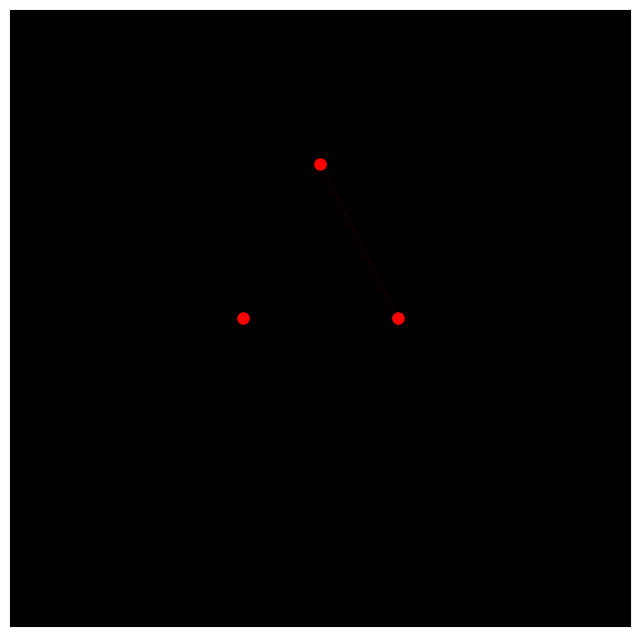

In [44]:
def animate(i):
    #setting our animated data to our organized numpy array, the index is going to correlate to a frame of our animation
    ln1.set_data([x1[i],x2[i],x3[i]],[y1[i],y2[i],y3[i]])
#setting up plot stuff
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ln1, = plt.plot([],[],'ro--', lw=0.1,markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
#the object takes in the function animate as a parameter and takes in the approperial frames and framerate interval
ani = animation.FuncAnimation(fig,animate,frames=1000,interval=25)
#exports as gif
ani.save('3body.gif', writer = 'pillow', fps=25)